# Comparing projections
-----------------
In this notebook, we compare the different bipartite projection approaches. The following approaches are the benefits.

1. Unweighted Projection. (UP)
2. Simple Weighted Projection. (SWP)
3. Neighboorhod Projection. (Master's approach) (NP)
4. Resource Allocation Projection. (RAP)
4. Normalized Resource Allocation Projection. (NRAP)

We analize the following properties in the projected networks.

* Weight Degree Distribution
* Modularity

In [1]:
### Import libraries

import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
from itertools import combinations 

In [2]:
### Load dataset

filename = "../data/HC/binet-HC-Ex.gml"
graph = ig.read(filename)

print(graph.summary()) # Show information about the graph

# Remove inutil variables
del filename

IGRAPH UNWT 3440 7586 -- 
+ attr: id (v), name (v), ranking (v), type (v), weight (e)


In [4]:
a_proj, b_proj = graph.bipartite_projection()
print(a_proj.summary())

IGRAPH UNWT 22 99 -- 
+ attr: id (v), name (v), ranking (v), type (v), weight (e)


In [45]:
def calculate_log_binning(degree_distribution, n_bins):
    """Compute the log-binning y-values in the degree distribution.

    Divides the degree distribution in `n_bins` segments.

    Parameters
    ----------
    degree_distribution: list
        Network degree distribution.
    n_bins:
        Number of bins to assign.

    Returns
    -------
    (list, list)
        The (x_values, y_values_log_bin_list) tuple.
    """
    current_sum = 0
    previous_k = 0
    y_values_log_bin_list = []
    x_values = []

    for i in range(1, n_bins):
        x_values.append(previous_k)
        current_k = 2 ** (i)
        current_sum = current_sum + current_k
        temp_y_value = sum(degree_distribution[previous_k:current_k])
        temp_y_value = temp_y_value / (current_k-previous_k)
        y_values_log_bin_list.append(temp_y_value)
        previous_k = current_k

        if current_sum > len(degree_distribution):
            x_values.append(previous_k)
            temp_y_value = sum(
                degree_distribution[previous_k:len(degree_distribution)])
            temp_y_value = temp_y_value / (len(degree_distribution)-previous_k)
            y_values_log_bin_list.append(temp_y_value)
            break

    return x_values, y_values_log_bin_list

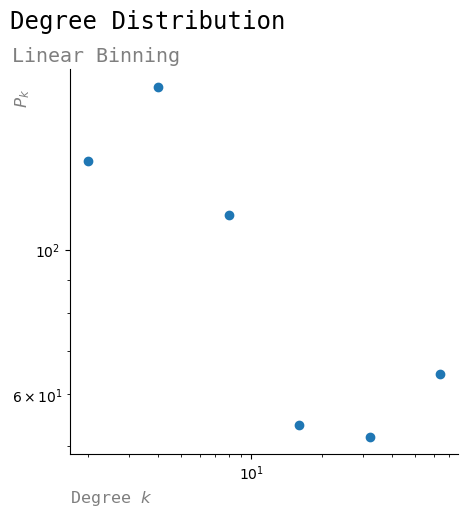

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
n_log_bin = ceil(log2(max(a_proj.es["weight"])))
x_values, y_values = calculate_log_binning(a_proj.es["weight"], n_log_bin)
ax.plot(x_values, y_values, "o", ls='None')
#ax.plot(range(max_degree), test, ls="--")
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

6.71
0.7251246250556325
[0.01087687 0.10550563 0.19795902 0.0808514  0.05800997 0.09354108
 0.09462876 0.0558346  0.02139118 0.00652612]
[-3.20440134 -1.82532806 -0.44625477  0.93281852  2.3118918   3.69096509
  5.07003838  6.44911166  7.82818495  9.20725824 10.58633152]


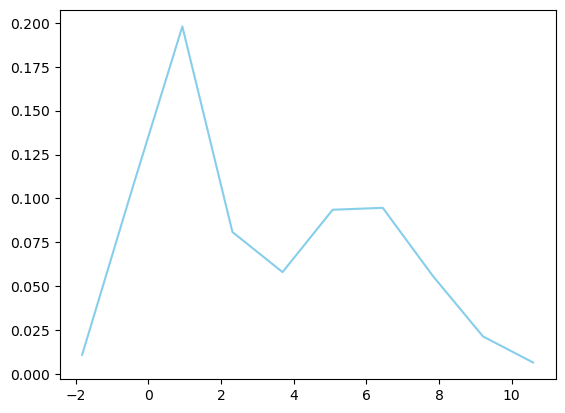

In [78]:
data = [0.1,0.04,0.5,0.33,0.4,0.2,0.30,0.8,0.9,0.95,0.5,0.66,0.33,0.7]
print(sum(data))
hist, bin_edges = np.histogram(a, bins=10, density=True)
print(sum(hist))
print(hist)
print(bin_edges)
plt.plot(bin_edges[1:], hist, color='skyblue', linestyle='-')

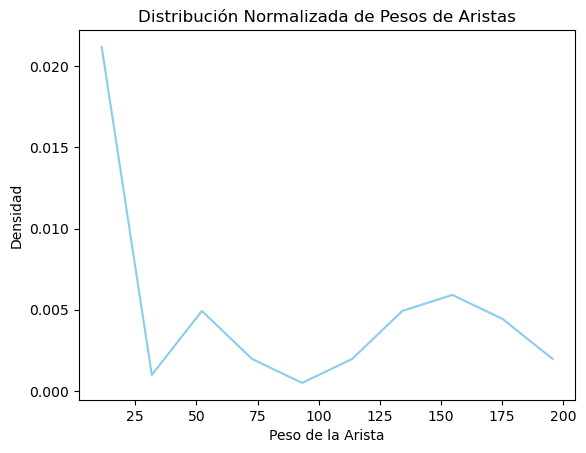

In [55]:

weights = a_proj.es["weight"]

# Calcular el histograma normalizado de los pesos de las aristas
hist, bin_edges = np.histogram(weights, bins=10, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Graficar la distribución de pesos como una línea continua
plt.plot(bin_centers, hist, color='skyblue', linestyle='-')


# Configurar el título y etiquetas de los ejes
plt.title('Distribución Normalizada de Pesos de Aristas')
plt.xlabel('Peso de la Arista')
plt.ylabel('Densidad')

# Mostrar la gráfica
plt.show()

In [8]:
### Auxiliar functions
from math import log2, ceil # for plot_weight_distribution

# Plot weight distribution
def plot_weight_distribution(network):
    """Plot weight distribution of a weighted network."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.loglog()
    ax.spines[['right', 'top']].set_visible(False)
    n_log_bin = ceil(log2(max(graph.degree())))
    x_values, y_values = calculate_log_binning(degree_list, n_log_bin)
    ax.plot(x_values, y_values, "o", ls='None')
    #ax.plot(range(max_degree), test, ls="--")
    ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
    ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
                   parse_math=True)
    ax.yaxis.set_label_coords(-0.1,0.95)
    ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
    plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
    plt.show()


def up_projection(biparte_network):
    """ Unweighted simple projection. """
    
    # Check if the bipartite network is a bipartite network:
    if not biparte_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")
    
    # Select types of nodes
    top_nodes = graph.vs.select(type=0)
    bot_nodes = graph.vs.select(type=1)
    
    top_proj = ig.Graph()
    for node in bot_nodes:
        # Get the neighborhood
        neis = node.neighbors()
        neis = [nodes["name"] for nodes in neis]
        
        # Use combinations
        edges = combinations(neis, 2)
        
                    
    return top_proj

        

In [ ]:
test = up_projection(graph)
print(test.summary())

In [18]:
perm = combinations([1, 2, 3], 2)
list(perm)

[(1, 2), (1, 3), (2, 3)]

In [ ]:
import igraph as ig

def proyeccion_grafo_bipartito_manual(grafo_bipartito, tipo_nodos):
    if len(tipo_nodos) != 2:
        raise ValueError("Se esperan exactamente dos tipos de nodos en el grafo bipartito.")
    
    # Verificar si los nodos son bipartitos
    if grafo_bipartito.is_bipartite(types=tipo_nodos):
        nodos_1 = grafo_bipartito.vs.select(type_eq=tipo_nodos[0])
        nodos_2 = grafo_bipartito.vs.select(type_eq=tipo_nodos[1])
        
        # Crear un nuevo grafo vacío para la proyección
        proyeccion = ig.Graph(directed=False)
        
        # Agregar vértices correspondientes a los nodos de un tipo
        proyeccion.add_vertices(len(nodos_1) + len(nodos_2))
        proyeccion.vs[:len(nodos_1)]["name"] = [str(n) for n in range(len(nodos_1))]
        proyeccion.vs[len(nodos_1):]["name"] = [str(n) for n in range(len(nodos_1), len(nodos_1) + len(nodos_2))]
        
        # Iterar sobre las aristas del grafo bipartito y agregar aristas a la proyección
        for edge in grafo_bipartito.es:
            source_type = grafo_bipartito.vs[edge.source]["type"]
            target_type = grafo_bipartito.vs[edge.target]["type"]
            if source_type != target_type:  # Solo agregar aristas entre nodos de tipos diferentes
                source_idx = edge.source if source_type == tipo_nodos[0] else edge.target
                target_idx = edge.target if source_type == tipo_nodos[0] else edge.source
                source_idx -= len(nodos_1) if source_type == tipo_nodos[1] else 0
                target_idx -= len(nodos_1) if target_type == tipo_nodos[1] else 0
                proyeccion.add_edge(source_idx, target_idx)
        
        return proyeccion
    else:
        raise ValueError("El grafo no es bipartito o no contiene los tipos de nodos especificados.")


In [57]:
node_u = 2
node_v = 4
vecinos_grados = [4] # Se almacenan grados d
vecinos_pesos_u = [0.06] # Se almacenan los pesos
vecinos_pesos_v = [0.05] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0
for i in range(len(vecinos_grados)):
    temp = vecinos_pesos_u[i] / (vecinos_grados[i]*node_u)
    primer_suma += temp
    temp = vecinos_pesos_v[i] / (vecinos_grados[i]*node_v)
    segunda_suma += temp

wwight = (primer_suma + segunda_suma) / 2
wwight

0.0053124999999999995

In [19]:
node_u = [0.11]
node_v = [0.03,0.05]
vecinos_grados = [0.11,0.03,0.08,0.3] # Se almacenan grados d
vecinos_pesos_u = [0.11] # Se almacenan los pesos
vecinos_pesos_v = [0.03] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0

primer_suma = vecinos_pesos_u[0] / ((sum(vecinos_grados)*4)*(sum(node_u)*1))
print(primer_suma)
segunda_suma = vecinos_pesos_v[0] / ((sum(vecinos_grados)*4)*(sum(node_v)*2))
print(segunda_suma)
wwight = (primer_suma + segunda_suma) / 2
wwight

0.4807692307692308
0.09014423076923075


0.2854567307692308

In [59]:
#aaaa
node_u = [0.11]
node_v = [0.03,0.05]
vecinos_grados = [0.11,0.03,0.08,0.3] # Se almacenan grados d
vecinos_pesos_u = [0.8521] # Se almacenan los pesos
vecinos_pesos_v = [0.8521] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0

primer_suma = vecinos_pesos_u[0] / (4)
print(primer_suma)
segunda_suma = vecinos_pesos_v[0] / (8)
print(segunda_suma)
wwight = (primer_suma + segunda_suma) / 2
wwight


0.213025
0.1065125


0.15976875

In [60]:
node_u = [0.11]
node_v = [0.08,0.2]
vecinos_grados = [0.11,0.03,0.08,0.3] # Se almacenan grados d
vecinos_pesos_u = [0.11] # Se almacenan los pesos
vecinos_pesos_v = [0.08] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0

primer_suma = vecinos_pesos_u[0] / (4)
print(primer_suma)
segunda_suma = vecinos_pesos_v[0] / (8)
print(segunda_suma)
wwight = (primer_suma + segunda_suma) / 2
wwight

0.0275
0.01


0.01875

In [61]:
# AAAAAA
node_u = [0.11]
node_v = [0.08,0.2]
vecinos_grados = [0.11,0.03,0.08,0.3] # Se almacenan grados d
vecinos_pesos_u = [0.9417] # Se almacenan los pesos
vecinos_pesos_v = [0.9417] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0

primer_suma = vecinos_pesos_u[0] / (4)
print(primer_suma)
segunda_suma = vecinos_pesos_v[0] / (8)
print(segunda_suma)
wwight = (primer_suma + segunda_suma) / 2
wwight

0.235425
0.1177125


0.17656875

In [5]:
node_u = [0.11]
node_v = [0.08,0.2]
vecinos_grados = [0.11,0.03,0.08,0.3] # Se almacenan grados d
vecinos_pesos_u = [0.11] # Se almacenan los pesos
vecinos_pesos_v = [0.08] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0

primer_suma = vecinos_pesos_u[0] / ((sum(vecinos_grados))+sum(node_u))
print(primer_suma)
segunda_suma = vecinos_pesos_v[0] / ((sum(vecinos_grados))+sum(node_v))
print(segunda_suma)
wwight = (primer_suma + segunda_suma) / 2
wwight

0.1746031746031746
0.09999999999999999


0.13730158730158729

In [4]:
node_u = [0.11]
node_v = [0.03,0.05]
vecinos_grados = [0.11,0.03,0.08,0.3] # Se almacenan grados d
vecinos_pesos_u = [0.11] # Se almacenan los pesos
vecinos_pesos_v = [0.03] # Se almacenan los pesos

primer_suma = 0
segunda_suma = 0

primer_suma = vecinos_pesos_u[0] / ((sum(vecinos_grados))+sum(node_u))
print(primer_suma)
segunda_suma = vecinos_pesos_v[0] / ((sum(vecinos_grados))+sum(node_v))
print(segunda_suma)
wwight = (primer_suma + segunda_suma) / 2
wwight

0.1746031746031746
0.05


0.11230158730158729

In [63]:
# Maestría pesos bipartito
node_u = [0.11]
node_v = [0.08, 0.2]
#vecinos_grados = [4] # Se almacenan grados d
vecinos_pesos_u = [0.11] # Se almacenan los pesos
vecinos_pesos_v = [0.08] # Se almacenan los pesos

parte_a = sum(vecinos_pesos_u) / sum(node_u)
parte_b = sum(vecinos_pesos_v) / sum(node_v)
weight = parte_a*parte_b
weight

0.2857142857142857

In [26]:
0.01 * 0.9

0.009000000000000001

In [24]:
0.5*0.5

0.25

In [25]:
0.98 * 0.44

0.43119999999999997

In [30]:
def beneficio_multiplicacion(x, y, a):
    return x ** a * y ** a

# Ejemplo de uso
x1, y1 = 0.08, 0.9
x2, y2 = 0.5, 0.4
x3, y3 = 0.77, 0.78
x3, y3 = 0.1, 0.1

a = 2  # Puedes ajustar este valor según tus necesidades

resultado1 = beneficio_multiplicacion(x1, y1, a)
resultado2 = beneficio_multiplicacion(x2, y2, a)
resultado3 = beneficio_multiplicacion(x3, y3, a)

print("Resultado 1:", resultado1)
print("Resultado 2:", resultado2)
print("Resultado 3:", resultado3)

Resultado 1: 0.005184
Resultado 2: 0.04000000000000001
Resultado 3: 0.00010000000000000005


In [4]:
import math

def beneficio_multiplicacion(x, y, alpha):
    return math.exp(-alpha * abs(x - y))

# Ejemplo de uso
x1, y1 = 0.11, 0.03
x2, y2 = 0.11, 0.08
x3, y3 = 0.77, 0.78
x4, y4 = 0.9, 0.01

alpha = 2  # Puedes ajustar este valor según tus necesidades

resultado1 = beneficio_multiplicacion(x1, y1, alpha)
resultado2 = beneficio_multiplicacion(x2, y2, alpha)
resultado3 = beneficio_multiplicacion(x3, y3, alpha)
resultado4 = beneficio_multiplicacion(x4, y4, alpha)

print("Resultado 1:", resultado1)
print("Resultado 2:", resultado2)
print("Resultado 3:", resultado3)
print("Resultado 4:", resultado4)

Resultado 1: 0.8521437889662113
Resultado 2: 0.9417645335842487
Resultado 3: 0.9801986733067553
Resultado 4: 0.1686381472685955


In [3]:
import math

def beneficio_multiplicacion(x, y, alpha):
    if x == y:
        return 1
    return ((x-y) * (x-y))

# Ejemplo de uso
x1, y1 = 0.11, 0.11
x2, y2 = 0.5, 0.4
x4, y4 = 0.9, 0.01
x3, y3 = 0.77, 0.78

alpha = 2  # Puedes ajustar este valor según tus necesidades

resultado1 = beneficio_multiplicacion(x1, y1, alpha)
resultado2 = beneficio_multiplicacion(x2, y2, alpha)
resultado3 = beneficio_multiplicacion(x3, y3, alpha)
resultado4 = beneficio_multiplicacion(x4, y4, alpha)

print("Resultado 1:", resultado1)
print("Resultado 2:", resultado2)
print("Resultado 3:", resultado3)
print("Resultado 4:", resultado4)

Resultado 1: 1
Resultado 2: 0.009999999999999995
Resultado 3: 0.00010000000000000018
Resultado 4: 0.7921


In [5]:
import math

def beneficio_multiplicacion(x, y, alpha):
    if x == y:
        return 1
    return (abs(x - y) + abs(x-y)) / 2

# Ejemplo de uso
x1, y1 = 0.11, 0.11
x2, y2 = 0.5, 0.4
x4, y4 = 0.9, 0.1
x3, y3 = 0.77, 0.78

alpha = 2  # Puedes ajustar este valor según tus necesidades

resultado1 = beneficio_multiplicacion(x1, y1, alpha)
resultado2 = beneficio_multiplicacion(x2, y2, alpha)
resultado3 = beneficio_multiplicacion(x3, y3, alpha)
resultado4 = beneficio_multiplicacion(x4, y4, alpha)

print("Resultado 1:", resultado1)
print("Resultado 2:", resultado2)
print("Resultado 3:", resultado3)
print("Resultado 4:", resultado4)

Resultado 1: 1
Resultado 2: 0.09999999999999998
Resultado 3: 0.010000000000000009
Resultado 4: 0.8


In [53]:
def funcion_normalizada_simple(x, y, alpha):
    if x==y:
        return 1
    return 1 / (1 + abs(x-y))

alpha=1
# Ejemplo de uso
x1, y1 = 0.11, 0.11
x3, y3 = 0.77, 0.78
x2, y2 = 0.5, 0.4
x4, y4 = 0.8, 0.2
x5, y5 = 0.99, 0.01

resultado1 = funcion_normalizada_simple(x1, y1, alpha)
resultado2 = funcion_normalizada_simple(x3, y3, alpha)
resultado3 = funcion_normalizada_simple(x2, y2, alpha)
resultado4 = funcion_normalizada_simple(x4, y4, alpha)
resultado5 = funcion_normalizada_simple(x5, y5, alpha)

print("Resultado 1:", resultado1)
print("Resultado 2:", resultado2)
print("Resultado 3:", resultado3)
print("Resultado 4:", resultado4)
print("Resultado 5:", resultado5)

Resultado 1: 1
Resultado 2: 0.9900990099009901
Resultado 3: 0.9090909090909091
Resultado 4: 0.625
Resultado 5: 0.5050505050505051


In [54]:
def funcion_normalizada_simple(x, y, alpha):
    if x==y:
        return 1
    return 1 / (1 + (abs(x-y)**alpha))

alpha=1
# Ejemplo de uso
x1, y1 = 0.11, 0.11
x3, y3 = 0.77, 0.78
x2, y2 = 0.5, 0.4
x2, y2 = 0.6, 0.3
x4, y4 = 0.8, 0.2
x5, y5 = 0.99, 0.01

resultado1 = funcion_normalizada_simple(x1, y1, alpha)
resultado2 = funcion_normalizada_simple(x3, y3, alpha)
resultado3 = funcion_normalizada_simple(x2, y2, alpha)
resultado4 = funcion_normalizada_simple(x4, y4, alpha)
resultado5 = funcion_normalizada_simple(x5, y5, alpha)

print("Resultado 1:", resultado1)
print("Resultado 2:", resultado2)
print("Resultado 3:", resultado3)
print("Resultado 4:", resultado4)
print("Resultado 5:", resultado5)

Resultado 1: 1
Resultado 2: 0.9900990099009901
Resultado 3: 0.7692307692307692
Resultado 4: 0.625
Resultado 5: 0.5050505050505051


In [39]:
x1, y1 = 0.99, 0.01
abs(x1-y1)/4 + abs(x1-y1)/8 # Mucha diferencia

0.3675

In [40]:
x1, y1 = 0.11, 0.12
abs(x1-y1)/4 + abs(x1-y1)/8 # Mucha diferencia

0.003749999999999998

In [45]:
x1, y1 = 0.11, 0.03
funcion_normalizada_simple(x1,y1,alpha)/4 + funcion_normalizada_simple(x1,y1,alpha)/8 # Mucha diferencia

0.3472222222222222

In [46]:
x1, y1 = 0.11, 0.08
funcion_normalizada_simple(x1,y1,alpha)/4 + funcion_normalizada_simple(x1,y1,alpha)/8 # Mucha diferencia

0.3640776699029126

In [55]:
x1, y1 = 0.01, 0.01
funcion_normalizada_simple(x1,y1,alpha)/2 + funcion_normalizada_simple(x1,y1,alpha)/2 # Mucha diferencia

1.0

In [77]:
import math

def distancia_minkowski_modificada(x, y, p):
    distancia_absoluta = abs(x - y)
    log_distancia = math.log(distancia_absoluta + 1)
    distancia_modificada = 1 / (1 + (log_distancia) ** p)
    return distancia_modificada

# Ejemplos
x1, y1 = 0.99, 0.01
x2, y2 = 0.2, 0.8
x3, y3 = 0.3, 0.7
x4, y4 = 0.4, 0.6
x5, y5 = 0.54, 0.55


for p_valor in [0.5, 1, 2, 3]:
    print(f"Para p = {p_valor}:")
    print(f"Ejemplo 1: {distancia_minkowski_modificada(x1, y1, p_valor)}")
    print(f"Ejemplo 2: {distancia_minkowski_modificada(x2, y2, p_valor)}")
    print(f"Ejemplo 3: {distancia_minkowski_modificada(x3, y3, p_valor)}")
    print(f"Ejemplo 4: {distancia_minkowski_modificada(x4, y4, p_valor)}")
    print(f"Ejemplo 5: {distancia_minkowski_modificada(x5, y5, p_valor)}")

Para p = 0.5:
Ejemplo 1: 0.5474961896034137
Ejemplo 2: 0.5932717852728494
Ejemplo 3: 0.6328864496264116
Ejemplo 4: 0.7007751281055918
Ejemplo 5: 0.9092964554558056
Para p = 1:
Ejemplo 1: 0.5941428760591696
Ejemplo 2: 0.6802704293411191
Ejemplo 3: 0.7482385137517997
Ejemplo 4: 0.8457935950281179
Ejemplo 5: 0.9901477027639939
Para p = 2:
Ejemplo 1: 0.6818392726962385
Ejemplo 2: 0.8190656120519737
Ejemplo 3: 0.8983002278511898
Ejemplo 4: 0.9678282750648652
Ejemplo 5: 0.9999010007177407
Para p = 3:
Ejemplo 1: 0.7582952550050038
Ejemplo 2: 0.9059403736875762
Ejemplo 3: 0.9633046233473311
Ejemplo 4: 0.9939759311100678
Ejemplo 5: 0.9999990148278264


In [2]:
def funcion_normalizada_simple(x, y):
    if x==y:
        return 1
    return 1 / (1 + abs(x-y))

ki = 1
kj = 4
kz = [4]
biz = [0.11]
bjz = [0.03]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = 1 / (1 + abs(biz[i]-bjz[i]) )
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  0.9259259259259258
Partei 0.23148148148148145 	 Partej 0.057870370370370364


0.2893518518518518

In [109]:
ki = 1
kj = 2
kz = [4]
biz = [0.11]
bjz = [0.08]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = 1 / (1 + abs(biz[i]-bjz[i]) )
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  0.970873786407767
Partei 0.24271844660194175 	 Partej 0.12135922330097088


0.3640776699029126

In [107]:
ki = 2
kj = 2
kz = [4,4]
biz = [0.03, 0.05]
bjz = [0.08, 0.02]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = 1 / (1 + abs(biz[i]-bjz[i]) )
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    print()

peso = (partei + partej)
peso

Vecino =  0
Numerador:  0.9523809523809523
Partei 0.11904761904761904 	 Partej 0.11904761904761904

Vecino =  1
Numerador:  0.970873786407767
Partei 0.24040684234858992 	 Partej 0.24040684234858992



0.48081368469717983

In [106]:
ki = 1
kj = 1
kz = [4]
biz = [0.08]
bjz = [0.1]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = 1 / (1 + abs(biz[i]-bjz[i]) )
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    print()
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  0.9803921568627451
Partei 0.24509803921568626 	 Partej 0.24509803921568626



0.49019607843137253

In [105]:
ki = 1
kj = 1
kz = [4]
biz = [0.03]
bjz = [0.1]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = 1 / (1 + abs(biz[i]-bjz[i]) )
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    print()
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  0.9345794392523364
Partei 0.2336448598130841 	 Partej 0.2336448598130841



0.4672897196261682

In [130]:
ki = 3
kj = 3
kz = [2,2,2]
biz = [0.12,0.9,0.22]
bjz = [0.12,0.9,0.22]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = funcion_normalizada_simple(biz[i], bjz[i])    
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    print()
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  1
Partei 0.16666666666666666 	 Partej 0.16666666666666666

Vecino =  1
Numerador:  1
Partei 0.3333333333333333 	 Partej 0.3333333333333333

Vecino =  2
Numerador:  1
Partei 0.5 	 Partej 0.5



1.0

In [131]:
ki = 3
kj = 3
kz = [2,2,3]
biz = [0.12,0.9,0.22]
bjz = [0.12,0.9,0.22]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = funcion_normalizada_simple(biz[i], bjz[i])    
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    print()
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  1
Partei 0.16666666666666666 	 Partej 0.16666666666666666

Vecino =  1
Numerador:  1
Partei 0.3333333333333333 	 Partej 0.3333333333333333

Vecino =  2
Numerador:  1
Partei 0.4444444444444444 	 Partej 0.4444444444444444



0.8888888888888888

In [176]:
ki = 4
kj = 2
kz = [4,2]
biz = [0.1,0.05]
bjz = [0.06,0.08]

partei, partej = 0, 0
for i in range(len(kz)):
    print("Vecino = ", i)
    numerador = funcion_normalizada_simple(biz[i], bjz[i])    
    print("Numerador: ", numerador)
    partei += numerador / (ki*kz[i])
    partej += numerador / (kj*kz[i])
    print("Partei", partei, "\t Partej", partej)
    print()
    
peso = (partei + partej)
peso

Vecino =  0
Numerador:  0.9615384615384615
Partei 0.06009615384615384 	 Partej 0.12019230769230768

Vecino =  1
Numerador:  0.970873786407767
Partei 0.18145537714712473 	 Partej 0.36291075429424946



0.5443661314413741